## Fit manifold learning algorithms to Cell Painting profiles

In [1]:
import pathlib
import numpy as np
import pandas as pd
import umap

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pycytominer.cyto_utils import infer_cp_features

In [2]:
np.random.seed(42)

In [3]:
# Output file info
output_dir = pathlib.Path("embeddings")
batch1_output_file = pathlib.Path(f"{output_dir}/cellpainting_embeddings_batch1.tsv.gz")
batch2_output_file = pathlib.Path(f"{output_dir}/cellpainting_embeddings_batch2.tsv.gz")

In [4]:
# Load cell painting profiles
file = pathlib.Path("cellpainting_lvl4_cpd_replicate_datasets", "cp_level4_cpd_replicates.csv.gz")
df = pd.read_csv(file, low_memory=False)

cp_features = infer_cp_features(df)
meta_features = infer_cp_features(df, metadata=True) + ["broad_id", "pert_iname", "moa", "replicate_name"]

# Transform PCA to top 50 components
n_components = 50
pca = PCA(n_components=n_components)

pca_df = pca.fit_transform(df.loc[:, cp_features])
pca_df = pd.DataFrame(pca_df)
pca_df.columns = [f"PCA_{x}" for x in range(0, n_components)]

print(pca_df.shape)
pca_df.head()

(51833, 50)


,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,...,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49
0,-42.122679,4.085155,1.754499,2.638896,-1.875468,-1.641374,-4.983540,-1.004442,-0.790192,-1.645856,...,1.124100,-0.228313,-0.448549,0.060850,0.696054,1.607458,-1.076220,2.737164,0.642807,-1.518541
1,-40.427803,5.733476,2.008065,1.710771,-0.033602,1.391462,-4.448982,-2.163253,-3.063314,-2.835545,...,0.336507,-1.294268,1.010514,-0.308424,0.644791,-2.338020,-0.732707,1.258569,0.675326,0.865343
2,-41.532214,4.692998,2.222982,2.239910,-0.384250,1.688658,-4.648900,-3.568407,-3.135225,-0.809053,...,-1.438761,0.840556,-0.513662,0.553876,-0.437972,-0.094944,-0.287905,0.653103,0.457734,0.379966
3,-42.097274,5.477119,0.077845,1.591351,-2.390238,-1.525690,-4.751712,-2.836765,-1.610468,-2.003166,...,-0.341240,-0.227929,0.392730,-0.896521,0.513025,-0.039000,-0.086339,1.257439,0.905584,-0.585753
4,-44.465733,5.329302,2.503256,2.165931,-0.811462,0.092866,-6.655512,-2.449830,-0.122376,-2.843679,...,-3.314582,0.050146,0.131753,-0.153035,-0.686617,1.072495,0.155233,-0.150733,0.994065,0.674850


## UMAP - Batch 1

In [5]:
# Fit UMAP
reducer = umap.UMAP(random_state=123, min_dist=0.1, n_neighbors=20, metric="euclidean")
embedding_df = reducer.fit_transform(pca_df.drop(["PCA_0"], axis="columns"))

In [6]:
embedding_df = pd.DataFrame(embedding_df)
embedding_df.columns = ["UMAP_0", "UMAP_1"]
embedding_df = pd.concat(
    [
        df.loc[:, meta_features],
        embedding_df
    ],
    axis="columns"
)

embedding_df.head()

,Metadata_broad_sample,Metadata_pert_id,Metadata_Plate,Metadata_Well,Metadata_broad_id,Metadata_moa,Metadata_dose_recode,broad_id,pert_iname,moa,replicate_name,UMAP_0,UMAP_1
0,DMSO,NaN,SQ00015211,A01,NaN,NaN,0,DMSO,DMSO,Control vehicle,replicate_0,-2.938141,1.076877
1,DMSO,NaN,SQ00015211,A02,NaN,NaN,0,DMSO,DMSO,Control vehicle,replicate_1,-1.354305,2.154696
2,DMSO,NaN,SQ00015211,A03,NaN,NaN,0,DMSO,DMSO,Control vehicle,replicate_2,-3.554336,0.853065
3,DMSO,NaN,SQ00015211,A04,NaN,NaN,0,DMSO,DMSO,Control vehicle,replicate_3,-3.074828,2.441806
4,DMSO,NaN,SQ00015211,A05,NaN,NaN,0,DMSO,DMSO,Control vehicle,replicate_4,-4.099612,1.356202


<AxesSubplot:xlabel='UMAP_0', ylabel='UMAP_1'>

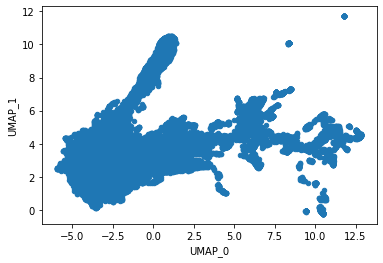

In [7]:
embedding_df.plot(x="UMAP_0", y="UMAP_1", kind="scatter")

## TSNE - Batch 1

In [8]:
tsne_reducer = TSNE(n_components=2, random_state=123, perplexity=30)
tsne_embedding_df = tsne_reducer.fit_transform(pca_df.drop(["PCA_0"], axis="columns"))

In [9]:
tsne_embedding_df = pd.DataFrame(tsne_embedding_df)
tsne_embedding_df.columns = ["TSNE_0", "TSNE_1"]
tsne_embedding_df = pd.concat(
    [
        df.loc[:, meta_features],
        tsne_embedding_df
    ],
    axis="columns"
)

<AxesSubplot:xlabel='TSNE_0', ylabel='TSNE_1'>

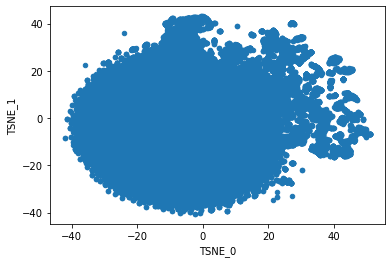

In [10]:
tsne_embedding_df.plot(x="TSNE_0", y="TSNE_1", kind="scatter")

### Merge data and output

In [11]:
embedding_df = embedding_df.merge(tsne_embedding_df, on=meta_features)

embedding_df = embedding_df.assign(dmso_label="DMSO")
embedding_df.loc[embedding_df.Metadata_broad_sample != "DMSO", "dmso_label"] = "compound"

embedding_df.to_csv(batch1_output_file, sep="\t", index=False)

print(embedding_df.shape)
embedding_df.head()

(51833, 16)


,Metadata_broad_sample,Metadata_pert_id,Metadata_Plate,Metadata_Well,Metadata_broad_id,Metadata_moa,Metadata_dose_recode,broad_id,pert_iname,moa,replicate_name,UMAP_0,UMAP_1,TSNE_0,TSNE_1,dmso_label
0,DMSO,NaN,SQ00015211,A01,NaN,NaN,0,DMSO,DMSO,Control vehicle,replicate_0,-2.938141,1.076877,-12.463080,-8.865612,DMSO
1,DMSO,NaN,SQ00015211,A02,NaN,NaN,0,DMSO,DMSO,Control vehicle,replicate_1,-1.354305,2.154696,14.516915,3.803647,DMSO
2,DMSO,NaN,SQ00015211,A03,NaN,NaN,0,DMSO,DMSO,Control vehicle,replicate_2,-3.554336,0.853065,-7.776953,-23.398987,DMSO
3,DMSO,NaN,SQ00015211,A04,NaN,NaN,0,DMSO,DMSO,Control vehicle,replicate_3,-3.074828,2.441806,-4.389498,-2.099470,DMSO
4,DMSO,NaN,SQ00015211,A05,NaN,NaN,0,DMSO,DMSO,Control vehicle,replicate_4,-4.099612,1.356202,-14.373955,-16.448122,DMSO


## UMAP - Batch 2

In [12]:
commit = "94bfaeeab0d107beac262b4307aa6e9b783625fa"
file = f"https://github.com/broadinstitute/lincs-cell-painting/raw/{commit}/spherized_profiles/profiles/2017_12_05_Batch2_dmso_spherized_profiles_with_input_normalized_by_whole_plate.csv.gz"

batch2_df = pd.read_csv(file, low_memory=False)

batch2_features = infer_cp_features(batch2_df)
batch2_meta_features = infer_cp_features(batch2_df, metadata=True)

# Transform PCA to top 50 components
pca = PCA(n_components=n_components)

pca_df = pca.fit_transform(batch2_df.loc[:, batch2_features])
pca_df = pd.DataFrame(pca_df)
pca_df.columns = [f"PCA_{x}" for x in range(0, n_components)]

print(pca_df.shape)
pca_df.head()

(51447, 50)


,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,...,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49
0,-1903.927757,-572.891324,1.657012,464.537693,-147.746339,90.601373,402.436087,190.831291,-67.870279,-224.656103,...,42.006516,31.599890,22.642956,-94.589394,-110.419190,-29.657944,-123.027818,93.259286,71.215954,-59.711704
1,-1904.532188,-572.921978,0.802678,464.497543,-147.734638,91.011500,402.148812,191.280208,-69.326058,-224.152123,...,41.808940,32.112882,23.226682,-94.605989,-111.674250,-30.121136,-124.116101,93.105537,71.451328,-59.806654
2,-1904.699316,-572.640292,1.453050,464.999682,-147.441654,93.009906,401.853484,190.697594,-69.258114,-223.703449,...,43.255229,31.353330,24.739199,-93.743673,-111.762062,-29.675776,-123.871406,92.855026,70.329788,-58.367341
3,-1516.764950,-243.321019,473.709897,706.972871,209.318175,122.799919,337.196467,13.252584,-562.427859,-93.375360,...,-165.656698,-1015.423515,-430.407422,234.521441,205.290847,-246.291142,117.255671,-484.560756,121.316456,932.407417
4,-1935.251981,-291.503668,77.850347,554.953762,-379.890862,-103.976533,-10.850709,46.472324,-169.435067,191.382636,...,96.132341,366.202288,-412.430777,-663.785128,315.745133,8.144525,-259.396802,34.132002,-45.461648,328.792529


In [13]:
# Fit UMAP
reducer = umap.UMAP(random_state=123, min_dist=0.1, n_neighbors=20, metric="euclidean")
batch2_embedding_df = reducer.fit_transform(pca_df)

batch2_embedding_df = pd.DataFrame(batch2_embedding_df)
batch2_embedding_df.columns = ["UMAP_0", "UMAP_1"]
batch2_embedding_df = pd.concat(
    [
        batch2_df.loc[:, batch2_meta_features],
        batch2_embedding_df
    ],
    axis="columns"
)

<AxesSubplot:xlabel='UMAP_0', ylabel='UMAP_1'>

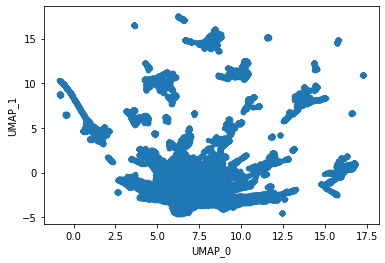

In [14]:
batch2_embedding_df.plot(x="UMAP_0", y="UMAP_1", kind="scatter")

In [15]:
# Fit TSNE
tsne_reducer = TSNE(n_components=2, random_state=123, perplexity=30)
tsne_embedding_df = tsne_reducer.fit_transform(pca_df)

tsne_embedding_df = pd.DataFrame(tsne_embedding_df)
tsne_embedding_df.columns = ["TSNE_0", "TSNE_1"]
tsne_embedding_df = pd.concat(
    [
        batch2_df.loc[:, batch2_meta_features],
        tsne_embedding_df
    ],
    axis="columns"
)

<AxesSubplot:xlabel='TSNE_0', ylabel='TSNE_1'>

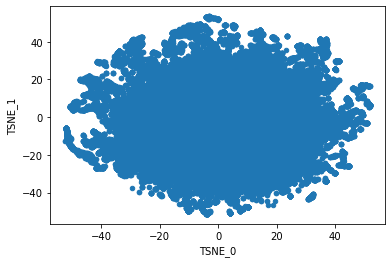

In [16]:
tsne_embedding_df.plot(x="TSNE_0", y="TSNE_1", kind="scatter")

In [17]:
batch2_embedding_df = batch2_embedding_df.merge(tsne_embedding_df, on=batch2_meta_features)

batch2_embedding_df = batch2_embedding_df.assign(dmso_label="DMSO")
batch2_embedding_df.loc[batch2_embedding_df.Metadata_broad_sample != "DMSO", "dmso_label"] = "compound"

# Output file
batch2_embedding_df.to_csv(batch2_output_file, sep="\t", index=False)

batch2_embedding_df.head()

,Metadata_plate_map_name,Metadata_cell_line,Metadata_time_point,Metadata_broad_sample,Metadata_mg_per_ml,Metadata_mmoles_per_liter,Metadata_solvent,Metadata_volume_ul,Metadata_amount_mg,Metadata_Plate,...,Metadata_alternative_moa,Metadata_alternative_target,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_dose_recode,UMAP_0,UMAP_1,TSNE_0,TSNE_1,dmso_label
0,LKCP001_MCF7_6H,MCF7,6H,DMSO,0.00000,0.0,DMSO,10,0.000,BR00092670,...,NaN,NaN,BR00092670,LKCP001_MCF7_6H,1,6.469576,-4.411047,1.931575,-5.647537,DMSO
1,LKCP001_MCF7_6H,MCF7,6H,DMSO,0.00000,0.0,DMSO,10,0.000,BR00092670,...,NaN,NaN,BR00092670,LKCP001_MCF7_6H,1,6.202775,-3.773242,3.484661,-0.501468,DMSO
2,LKCP001_MCF7_6H,MCF7,6H,DMSO,0.00000,0.0,DMSO,10,0.000,BR00092670,...,NaN,NaN,BR00092670,LKCP001_MCF7_6H,1,6.232362,-4.093251,7.047605,-5.857838,DMSO
3,LKCP001_MCF7_6H,MCF7,6H,BRD-K63828191-003-28-9,5.10040,10.0,DMSO,10,0.051,BR00092670,...,NaN,NaN,BR00092670,LKCP001_MCF7_6H,6,4.813786,0.695502,12.999969,29.152693,compound
4,LKCP001_MCF7_6H,MCF7,6H,BRD-K63828191-003-28-9,0.51004,1.0,DMSO,10,0.005,BR00092670,...,NaN,NaN,BR00092670,LKCP001_MCF7_6H,4,6.864016,-0.844567,-7.146823,0.484434,compound
